##### Copyright 2023 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Automated hyper-parameter tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/decision_forests/tutorials/automatic_tuning_colab"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/automatic_tuning_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/decision-forests/blob/main/documentation/tutorials/automatic_tuning_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/decision-forests/documentation/tutorials/automatic_tuning_colab.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Welcome to the **Automated hyper-parameter tuning** tutorial. In this colab, you
will learn how to improve your models using automated hyper-parameter tuning
with TensorFlow Decision Forests.

More precicely we will:

1.  Train a model **without hyper-parameter tuning**. This model will be used to
    measure the quality improvement of hyper-parameter tuning.
1.  Train a model **with hyper-parameter tuning** using **TF-DF's tuner**. The
    hyper-parameters to optimize will be **defined manually**.
1.  Train another model **with hyper-parameter tuning** using **TF-DF's tuner**.
    But this time, the hyper-parameters to optimize will be **set
    automatically**. **This is the recommanded first approach to try when using
    hyper-parameter tuning**.
1.  Finally, we will train a model **with hyper-parameter tuning** using
    **Keras's tuner**.

## Introduction

A learning algorithm trains a machine learning model on a training dataset. The
parameters of a learning algorithm&ndash;called "hyper-parameters"&ndash;control
how the model is trained and impact its quality. Therefore, finding the best
hyper-parameters is an important stage of modeling.

Some hyper-parameters are simple to configure. For example, increasing the
number of trees (`num_trees`) in a random forest increases the quality of the
model until a plateau. Therefore, setting the largest value compatible with the
serving constraints (more trees means a larger model) is a valid rule of thumb.
However, other hyper-parameters have a more complex interaction with the model
and cannot be chosen with such a simple rule. For example, increasing the
maximum tree depth (`max_depth`) of a gradient boosted tree model can both
increase or decrease the quality of the model. Furthermore, hyper-parameters can
interact between each others, and the optimal value of a hyper-parameter cannot
be found in isolation.

There are three main approaches to select the hyper-parameter values:

1.  **The default approach**: Learning algorithms come with default values.
    While not ideal in all cases, those values produce reasonable results in
    most situations. This approach is recommended as the first approach to use
    in any modeling.
    [This page](https://github.com/google/yggdrasil-decision-forests/blob/main/documentation/learners.md)
    lists the default value of TF Decision Forests.

2.  **The template hyper-parameter approach**: In addition to the default
    values, TF Decision Forests also exposes the hyper-parameter templates.
    Those are benchmark-tuned hyper-parameter values with excellent performance
    but high training cost (e.g. `hyperparameter_template="benchmark_rank1"`).

3.  **The manual tuning approach:** You can manually test different
    hyper-parameter values and select the one that performs best.
    [The advanced users guide](https://github.com/google/yggdrasil-decision-forests/blob/main/documentation/user_manual.md#manual-tuning-of-hyper-parameters)
    give some advice.

4.  **The automated tuning approach:** A tuning algorithm can be used to find
    automatically the best hyper-parameter values. This approach gives often the
    best results and does not require expertise. The main downside of this
    approach is the time it takes for large datasets.

In this colab, we shows the **default** and **automated tuning** approaches with
the TensorFlow Decision Forests library.

## Hyper-parameter tuning algorithms

Automated tuning algorithms work by generating and evaluating a large number of
hyper-parameter values. Each of those iterations is called a "trial". The
evaluation of a trial is expensive as it requires to train a new model each
time. At the end of the tuning, the hyper-parameter with the best evaluation is
used.

Tuning algorithm are configured as follow:

**The search space**

The search space is the list of hyper-parameters to optimize and the values they
can take. For example, the maximum depth of a tree could be optimized for values
in between 1 and 32. Exploring more hyper-parameters and more possible values
often leads to better models but also takes more time. The hyper-parameters
listed in the
[user manual](https://github.com/google/yggdrasil-decision-forests/blob/main/documentation/user_manual.md#manual-tuning-of-hyper-parameters)
are the most impactful ones to tune. The other hyper-parameters are listed in
the
[documentation](https://github.com/google/yggdrasil-decision-forests/blob/main/documentation/learners.md).

When the possible value of one hyper-parameter depends on the value of another
hyper-parameter, the search space is said to be conditional.

**The number of trials**

The number of trials defines how many models will be trained and evaluated.
Larger number of trials generally leads to better models, but takes more time.

**The optimizer**

The optimizer selects the next hyper-parameter to evaluate the past trial
evaluations. The simplest and often reasonable optimizer is the one that selects
the hyper-parameter at random.

**The objective / trial score**

The objective is the metric optimized by the tuner. Often, this metric is a
measure of quality (e.g. accuracy, log loss) of the model evaluated on a
validation dataset.

*Train-valid-test*

The validation dataset should be different from the training datasets: If the
training and validation datasets are the same, the selected hyper-parameters
will be irrelevant. The validation dataset should also be different from the
testing dataset (also called holdout dataset): Because hyper-parameter tuning is
a form of training, if the testing and validation datasets are the same, you are
effectively training on the test dataset. In this case, you might overfit on
your test dataset without a way to measure it.

*Cross-validation*

In the case of a small dataset, for example a dataset with less than 100k
examples, hyper-parameter tuning can be coupled with
[cross-validation](https://en.wikipedia.org/wiki/Cross-validation_\(statistics\)):
Instead of being evaluated from a single training-test round, the
objective/trial score is evaluated as the average of the metric over multiple
cross-validation rounds.

Similarly as to the train-valid-and-test datasets, the cross-validation used to
evaluate the objective/score during hyper-parameter tuning should be different
from the cross-validation used to evaluate the quality of the model.

*Out-of-bag evaluation*

Some models, like Random Forests, can be evaluated on the training datasets
using the "out-of-bag evaluation" method. While not as accurate as
cross-validation, the "out-of-bag evaluation" is much faster than
cross-validation and does not require a separate validation datasets.

*In tensorflow decision forests*

In TF-DF, the model
["self" evaluation](https://www.tensorflow.org/decision_forests/tutorials/beginner_colab#model_self_evaluation)
is always a fair way to evaluate a model. For example, an out-of-bag evaluation
is used for Random Forest models while a validation dataset is used for Gradient
Boosted models.

## Hyper-parameter tuning with TF Decision Forests

TF-DF supports automatic hyper-parameter tuning with minimal configuration. In
the next example, we will train and compare two models: One trained with default
hyper-parameters, and one trained with hyper-parameter tuning.

**Note:** Hyper-parameters tuning can take a long time in the case of large
datasets. In this case, it is recommended to use TF-DF with distributed training
to drastically speed-up the hyper-parameter tuning.

## Setup

In [2]:
# Install TensorFlow Dececision Forests
!pip install tensorflow_decision_forests -U -qq

Install [Wurlitzer](https://pypi.org/project/wurlitzer/). Wurlitzer is required to show the detailed training logs in colabs (with `verbose=2`).

In [3]:
!pip install wurlitzer -U -qq

Import the necessary libraries.

In [4]:
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

2023-02-01 12:08:22.560223: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-01 12:08:22.560311: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-01 12:08:22.560320: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


The hidden code cell limits the output height in colab.

In [5]:
#@title Define "set_cell_height".

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

## Training a model **without** Automated hyper-parameter tuning

We will train a model on the [Adult](https://archive.ics.uci.edu/ml/datasets/adult) dataset available on the [UCI](https://archive.ics.uci.edu/ml/datasets/adult). Let's download the dataset.

In [6]:
# Download a copy of the adult dataset.
!wget -q https://raw.githubusercontent.com/google/yggdrasil-decision-forests/main/yggdrasil_decision_forests/test_data/dataset/adult_train.csv -O /tmp/adult_train.csv
!wget -q https://raw.githubusercontent.com/google/yggdrasil-decision-forests/main/yggdrasil_decision_forests/test_data/dataset/adult_test.csv -O /tmp/adult_test.csv

Split the dataset into a training and a testing dataset.

In [7]:
# Load the dataset in memory
train_df = pd.read_csv("/tmp/adult_train.csv")
test_df = pd.read_csv("/tmp/adult_test.csv")

# , and convert it into a TensorFlow dataset.
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="income")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="income")

First, we train and evaluate the quality of a [Gradient Boosted Trees](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/GradientBoostedTreesModel) model trained with the default hyper-parameters.

In [8]:
%%time
# Train a model with default hyper-parameters
model = tfdf.keras.GradientBoostedTreesModel()
model.fit(train_ds)

Use /tmpfs/tmp/tmpuk7pbkq8 as temporary training directory


Reading training dataset...


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:03.662891. Found 22792 examples.


Training model...


2023-02-01 12:08:32.432401: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-02-01 12:08:32.432437: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-02-01 12:08:32.432444: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:03.111172


Compiling model...


[INFO 2023-02-01T12:08:35.50196752+00:00 kernel.cc:1214] Loading model from path /tmpfs/tmp/tmpuk7pbkq8/model/ with prefix 951b90795cc74103
[INFO 2023-02-01T12:08:35.524444264+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2023-02-01T12:08:35.524475121+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model compiled.


CPU times: user 11.9 s, sys: 1.19 s, total: 13.1 s
Wall time: 8.25 s


In [9]:
# Evaluate the model
model.compile(["accuracy"])
test_accuracy = model.evaluate(test_ds, return_dict=True, verbose=0)["accuracy"]
print(f"Test accuracy without hyper-parameter tuning: {test_accuracy:.4f}")

Test accuracy without hyper-parameter tuning: 0.8744


The default hyper-parameters of the model are available with the `learner_params` function. The definition of those parameters is available in the [documentation](https://github.com/google/yggdrasil-decision-forests/blob/main/documentation/learners.md).

In [10]:
print("Default hyper-parameters of the model:\n", model.learner_params)

Default hyper-parameters of the model:
 {'adapt_subsample_for_maximum_training_duration': False, 'allow_na_conditions': False, 'apply_link_function': True, 'categorical_algorithm': 'CART', 'categorical_set_split_greedy_sampling': 0.1, 'categorical_set_split_max_num_items': -1, 'categorical_set_split_min_item_frequency': 1, 'compute_permutation_variable_importance': False, 'dart_dropout': 0.01, 'early_stopping': 'LOSS_INCREASE', 'early_stopping_initial_iteration': 10, 'early_stopping_num_trees_look_ahead': 30, 'focal_loss_alpha': 0.5, 'focal_loss_gamma': 2.0, 'forest_extraction': 'MART', 'goss_alpha': 0.2, 'goss_beta': 0.1, 'growing_strategy': 'LOCAL', 'honest': False, 'honest_fixed_separation': False, 'honest_ratio_leaf_examples': 0.5, 'in_split_min_examples_check': True, 'keep_non_leaf_label_distribution': True, 'l1_regularization': 0.0, 'l2_categorical_regularization': 1.0, 'l2_regularization': 0.0, 'lambda_loss': 1.0, 'loss': 'DEFAULT', 'max_depth': 6, 'max_num_nodes': None, 'maximu

## Training a model **with** automated hyper-parameter tuning and **manual** definition of the hyper-parameters

Hyper-parameter tuning is enabled by specifying the `tuner` constructor argument of the model. The tuner object contains all the configuration of the tuner (search space, optimizer, trial and objective).

**Note:** *In the next section, you will see how to automtically configure hyper-parameters values. However, setting the hyper-parameters manually as shown here is still valuable to understand.*

In [11]:
# Configure the tuner.

# Create a Random Search tuner with 50 trials.
tuner = tfdf.tuner.RandomSearch(num_trials=50)

# Define the search space.
#
# Adding more parameters generaly improve the quality of the model, but make
# the tuning last longer.

tuner.choice("min_examples", [2, 5, 7, 10])
tuner.choice("categorical_algorithm", ["CART", "RANDOM"])

# Some hyper-parameters are only valid for specific values of other
# hyper-parameters. For example, the "max_depth" parameter is mostly useful when
# "growing_strategy=LOCAL" while "max_num_nodes" is better suited when
# "growing_strategy=BEST_FIRST_GLOBAL".

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [3, 4, 5, 6, 8])

# merge=True indicates that the parameter (here "growing_strategy") is already
# defined, and that new values are added to it.
global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [16, 32, 64, 128, 256])

tuner.choice("use_hessian_gain", [True, False])
tuner.choice("shrinkage", [0.02, 0.05, 0.10, 0.15])
tuner.choice("num_candidate_attributes_ratio", [0.2, 0.5, 0.9, 1.0])

# Uncomment some (or all) of the following hyper-parameters to increase the
# quality of the search. The number of trial should be increased accordingly.

# tuner.choice("split_axis", ["AXIS_ALIGNED"])
# oblique_space = tuner.choice("split_axis", ["SPARSE_OBLIQUE"], merge=True)
# oblique_space.choice("sparse_oblique_normalization",
#                      ["NONE", "STANDARD_DEVIATION", "MIN_MAX"])
# oblique_space.choice("sparse_oblique_weights", ["BINARY", "CONTINUOUS"])
# oblique_space.choice("sparse_oblique_num_projections_exponent", [1.0, 1.5])

In [12]:
%%time
%set_cell_height 300

# Tune the model. Notice the `tuner=tuner`.
tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
tuned_model.fit(train_ds, verbose=2)

# The `num_threads` model constructor argument (not specified in the example
# above) controls how many trials are run in parallel (one per thread). If
# `num_threads` is not specified (like in the example above), one thread is
# allocated for each available CPU core.
#
# If the training is interrupted (for example, by pressing on the "stop" button
# on the top-left of the colab cell), the best model so-far will be returned.

# In the training logs, you can see lines such as `[10/50] Score: -0.45 / -0.40
# HParams: ...`. This indicates that 10 of the 50 trials have been completed.
# And that the last trial returned a score of "-0.45" and that the best trial so
# far has a score of "-0.40". In this example, the model is optimized by
# logloss. Since scores are maximized and log loss should be minimized, the
# score is effectively minus the log loss.

<IPython.core.display.Javascript object>

Use /tmpfs/tmp/tmpgjhxwzpg as temporary training directory


Reading training dataset...


Training tensor examples:
Features: {'age': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'workclass': <tf.Tensor 'data_13:0' shape=(None,) dtype=string>, 'fnlwgt': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'education': <tf.Tensor 'data_3:0' shape=(None,) dtype=string>, 'education_num': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'marital_status': <tf.Tensor 'data_7:0' shape=(None,) dtype=string>, 'occupation': <tf.Tensor 'data_9:0' shape=(None,) dtype=string>, 'relationship': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'race': <tf.Tensor 'data_10:0' shape=(None,) dtype=string>, 'sex': <tf.Tensor 'data_12:0' shape=(None,) dtype=string>, 'capital_gain': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'capital_loss': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hours_per_week': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'native_country': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>}
Label: Tensor("data_14:0", shape=(None,), dtype=int64)
Weights

Normalized tensor features:
 {'age': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'workclass': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_13:0' shape=(None,) dtype=string>), 'fnlwgt': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'education': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_3:0' shape=(None,) dtype=string>), 'education_num': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'marital_status': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_7:0' shape=(None,) dtype=string>), 'occupation': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_9:0' shape=(None,) dtype=string>), 'relationship': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_11:0' shape=(None,) d

Training dataset read in 0:00:00.385471. Found 22792 examples.


Training model...


Standard output detected as not visible to the user e.g. running in a notebook. Creating a training log redirection. If training gets stuck, try calling tfdf.keras.set_training_logs_redirection(False).


[INFO 2023-02-01T12:08:37.779610966+00:00 kernel.cc:756] Start Yggdrasil model training
[INFO 2023-02-01T12:08:37.779679473+00:00 kernel.cc:757] Collect training examples
[INFO 2023-02-01T12:08:37.77976402+00:00 kernel.cc:388] Number of batches: 23
[INFO 2023-02-01T12:08:37.779779517+00:00 kernel.cc:389] Number of examples: 22792


[INFO 2023-02-01T12:08:37.787405763+00:00 data_spec_inference.cc:303] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column native_country (40 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 2023-02-01T12:08:37.787447447+00:00 data_spec_inference.cc:303] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column occupation (13 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 2023-02-01T12:08:37.787485818+00:00 data_spec_inference.cc:303] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column workclass (7 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000


[INFO 2023-02-01T12:08:37.792400377+00:00 kernel.cc:774] Training dataset:
Number of records: 22792
Number of columns: 15

Number of columns by type:
	CATEGORICAL: 9 (60%)
	NUMERICAL: 6 (40%)

Columns:

CATEGORICAL: 9 (60%)
	0: "__LABEL" CATEGORICAL integerized vocab-size:3 no-ood-item
	4: "education" CATEGORICAL has-dict vocab-size:17 zero-ood-items most-frequent:"HS-grad" 7340 (32.2043%)
	8: "marital_status" CATEGORICAL has-dict vocab-size:8 zero-ood-items most-frequent:"Married-civ-spouse" 10431 (45.7661%)
	9: "native_country" CATEGORICAL num-nas:407 (1.78571%) has-dict vocab-size:41 num-oods:1 (0.00446728%) most-frequent:"United-States" 20436 (91.2933%)
	10: "occupation" CATEGORICAL num-nas:1260 (5.52826%) has-dict vocab-size:14 num-oods:1 (0.00464425%) most-frequent:"Prof-specialty" 2870 (13.329%)
	11: "race" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"White" 19467 (85.4115%)
	12: "relationship" CATEGORICAL has-dict vocab-size:7 zero-ood-items most-frequent:"Hu

learner: "HYPERPARAMETER_OPTIMIZER"
features: "^age$"
features: "^capital_gain$"
features: "^capital_loss$"
features: "^education$"
features: "^education_num$"
features: "^fnlwgt$"
features: "^hours_per_week$"
features: "^marital_status$"
features: "^native_country$"
features: "^occupation$"
features: "^race$"
features: "^relationship$"
features: "^sex$"
features: "^workclass$"
label: "^__LABEL$"
task: CLASSIFICATION
metadata {
  framework: "TF Keras"
}
[yggdrasil_decision_forests.model.hyperparameters_optimizer_v2.proto.hyperparameters_optimizer_config] {
  base_learner {
    learner: "GRADIENT_BOOSTED_TREES"
    features: "^age$"
    features: "^capital_gain$"
    features: "^capital_loss$"
    features: "^education$"
    features: "^education_num$"
    features: "^fnlwgt$"
    features: "^hours_per_week$"
    features: "^marital_status$"
    features: "^native_country$"
    features: "^occupation$"
    features: "^race$"
    features: "^relationship$"
    features: "^sex$"
    featu

[INFO 2023-02-01T12:08:39.851533704+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.583674


[INFO 2023-02-01T12:08:41.585165969+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.588227


[INFO 2023-02-01T12:08:42.092825385+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.569129


[INFO 2023-02-01T12:08:42.557544087+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.573016


[INFO 2023-02-01T12:08:42.602274077+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.575957


[INFO 2023-02-01T12:08:42.613803966+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.571689


[INFO 2023-02-01T12:08:43.519389753+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.575672


[INFO 2023-02-01T12:08:44.213780982+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.578549


[INFO 2023-02-01T12:08:44.759667214+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.573061


[INFO 2023-02-01T12:08:45.231593728+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.577748


[INFO 2023-02-01T12:08:45.479992055+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.578216


[INFO 2023-02-01T12:08:45.799623005+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.578669


[INFO 2023-02-01T12:08:45.964682066+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.586668


[INFO 2023-02-01T12:08:46.034461092+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.576506


[INFO 2023-02-01T12:08:47.555410961+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.578696


[INFO 2023-02-01T12:08:47.593686674+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.579464


[INFO 2023-02-01T12:08:47.838775628+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.574801


[INFO 2023-02-01T12:08:48.454877928+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.571936


[INFO 2023-02-01T12:08:48.711038125+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.587919


[INFO 2023-02-01T12:08:48.712049402+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.575719


[INFO 2023-02-01T12:08:48.946675629+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.578764


[INFO 2023-02-01T12:08:49.053943911+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.57629


[INFO 2023-02-01T12:08:49.315889807+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.581114


[INFO 2023-02-01T12:08:49.994744725+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.568287


[INFO 2023-02-01T12:08:52.573819212+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.570064


[INFO 2023-02-01T12:08:54.567070436+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.572158


[INFO 2023-02-01T12:08:58.961698295+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.573524


[INFO 2023-02-01T12:08:58.98892809+00:00 kernel.cc:905] Export model in log directory: /tmpfs/tmp/tmpgjhxwzpg with prefix 29a08c8a3f274273


[INFO 2023-02-01T12:08:58.995928198+00:00 kernel.cc:923] Save model in resources


[INFO 2023-02-01T12:08:58.998730119+00:00 abstract_model.cc:849] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.568287

Accuracy: 0.873395  CI95[W][0 1]
ErrorRate: : 0.126605


Confusion Table:
truth\prediction
   0     1    2
0  0     0    0
1  0  1570   94
2  0   192  403
Total: 2259

One vs other classes:



[INFO 2023-02-01T12:08:59.018306354+00:00 kernel.cc:1214] Loading model from path /tmpfs/tmp/tmpgjhxwzpg/model/ with prefix 29a08c8a3f274273


[INFO 2023-02-01T12:08:59.049560135+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2023-02-01T12:08:59.0495917+00:00 kernel.cc:1046] Use fast generic engine


Model trained in 0:00:21.277256


Compiling model...


Model compiled.


CPU times: user 6min 57s, sys: 332 ms, total: 6min 57s
Wall time: 21.9 s


In [13]:
# Evaluate the model
tuned_model.compile(["accuracy"])
tuned_test_accuracy = tuned_model.evaluate(test_ds, return_dict=True, verbose=0)["accuracy"]
print(f"Test accuracy with the TF-DF hyper-parameter tuner: {tuned_test_accuracy:.4f}")

Test accuracy with the TF-DF hyper-parameter tuner: 0.8722


The hyper-parameters and objective scores of the trials are available in the model inspector. The `score` value is always maximized. In this example, the score is the negative log loss on the validation dataset (selected automatically).

In [14]:
# Display the tuning logs.
tuning_logs = tuned_model.make_inspector().tuning_logs()
tuning_logs.head()

,score,evaluation_time,best,min_examples,categorical_algorithm,growing_strategy,max_depth,use_hessian_gain,shrinkage,num_candidate_attributes_ratio,max_num_nodes
0,-0.590370,2.027866,False,7,CART,LOCAL,3.0,true,0.15,0.2,NaN
1,-0.583674,2.062493,False,5,CART,LOCAL,8.0,true,0.15,0.2,NaN
2,-0.584009,3.336132,False,10,RANDOM,LOCAL,3.0,true,0.15,0.5,NaN
3,-0.581734,3.453046,False,10,CART,LOCAL,3.0,true,0.15,1.0,NaN
4,-0.588227,3.796232,False,7,CART,BEST_FIRST_GLOBAL,NaN,false,0.10,0.2,64.0


 The single rows with `best=True` is the one used in the final model.

In [15]:
# Best hyper-parameters.
tuning_logs[tuning_logs.best].iloc[0]

score                                     -0.568287
evaluation_time                           12.203865
best                                           True
min_examples                                      5
categorical_algorithm                          CART
growing_strategy                  BEST_FIRST_GLOBAL
max_depth                                       NaN
use_hessian_gain                               true
shrinkage                                       0.1
num_candidate_attributes_ratio                  0.9
max_num_nodes                                 256.0
Name: 34, dtype: object

**Note:** Parameters with NaN value are conditional parameters that are not set.

Next, we plot the evaluation of the best score during the tuning.

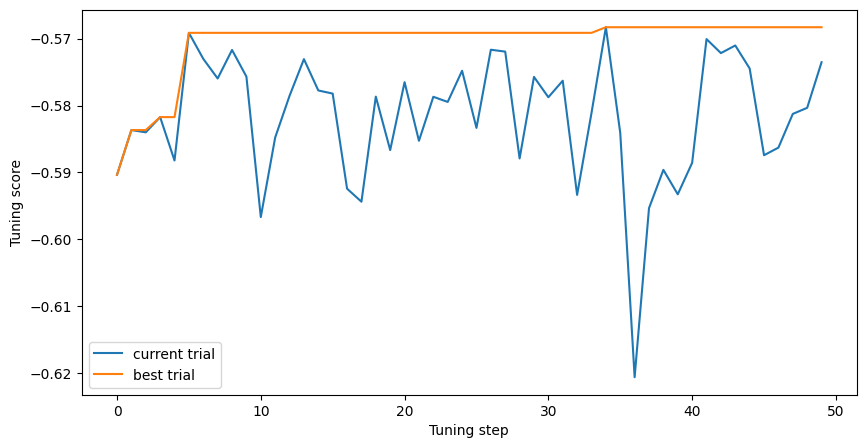

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(tuning_logs["score"], label="current trial")
plt.plot(tuning_logs["score"].cummax(), label="best trial")
plt.xlabel("Tuning step")
plt.ylabel("Tuning score")
plt.legend()
plt.show()

## Training a model **with** automated hyper-parameter tuning and **automatic** definition of the hyper-parameters (*recommended approach*)

As before, hyper-parameter tuning is enabled by specifying the `tuner` constructor argument of the model. Set `use_predefined_hps=True` to automatically configure the search space for the hyper-parameters.

**Note:** The automatic hyper-parameter configuration explores some powerful but slow to train hyper-parameters. For example, oblique splits (commented/disabled in the previous section; see `SPARSE_OBLIQUE`) are tested. This mean the tuning will be slower, but hopefully give a result of significantly higher quality.

In [17]:
%%time
%set_cell_height 300

# Create a Random Search tuner with 50 trials and automatic hp configuration.
tuner = tfdf.tuner.RandomSearch(num_trials=50, use_predefined_hps=True)

# Define and train the model.
tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
tuned_model.fit(train_ds, verbose=2)

<IPython.core.display.Javascript object>

Use /tmpfs/tmp/tmp7w1wg5fw as temporary training directory


Reading training dataset...


Training tensor examples:
Features: {'age': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'workclass': <tf.Tensor 'data_13:0' shape=(None,) dtype=string>, 'fnlwgt': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'education': <tf.Tensor 'data_3:0' shape=(None,) dtype=string>, 'education_num': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'marital_status': <tf.Tensor 'data_7:0' shape=(None,) dtype=string>, 'occupation': <tf.Tensor 'data_9:0' shape=(None,) dtype=string>, 'relationship': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'race': <tf.Tensor 'data_10:0' shape=(None,) dtype=string>, 'sex': <tf.Tensor 'data_12:0' shape=(None,) dtype=string>, 'capital_gain': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'capital_loss': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hours_per_week': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'native_country': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>}
Label: Tensor("data_14:0", shape=(None,), dtype=int64)
Weights

Normalized tensor features:
 {'age': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'workclass': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_13:0' shape=(None,) dtype=string>), 'fnlwgt': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'education': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_3:0' shape=(None,) dtype=string>), 'education_num': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'marital_status': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_7:0' shape=(None,) dtype=string>), 'occupation': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_9:0' shape=(None,) dtype=string>), 'relationship': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_11:0' shape=(None,) d

Training dataset read in 0:00:00.369788. Found 22792 examples.


Training model...


[INFO 2023-02-01T12:09:00.101003542+00:00 kernel.cc:756] Start Yggdrasil model training
[INFO 2023-02-01T12:09:00.101032435+00:00 kernel.cc:757] Collect training examples
[INFO 2023-02-01T12:09:00.101119151+00:00 kernel.cc:388] Number of batches: 23
[INFO 2023-02-01T12:09:00.101135203+00:00 kernel.cc:389] Number of examples: 22792


[INFO 2023-02-01T12:09:00.108672367+00:00 data_spec_inference.cc:303] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column native_country (40 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 2023-02-01T12:09:00.108716013+00:00 data_spec_inference.cc:303] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column occupation (13 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 2023-02-01T12:09:00.10875597+00:00 data_spec_inference.cc:303] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column workclass (7 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000


[INFO 2023-02-01T12:09:00.113672478+00:00 kernel.cc:774] Training dataset:
Number of records: 22792
Number of columns: 15

Number of columns by type:
	CATEGORICAL: 9 (60%)
	NUMERICAL: 6 (40%)

Columns:

CATEGORICAL: 9 (60%)
	0: "__LABEL" CATEGORICAL integerized vocab-size:3 no-ood-item
	4: "education" CATEGORICAL has-dict vocab-size:17 zero-ood-items most-frequent:"HS-grad" 7340 (32.2043%)
	8: "marital_status" CATEGORICAL has-dict vocab-size:8 zero-ood-items most-frequent:"Married-civ-spouse" 10431 (45.7661%)
	9: "native_country" CATEGORICAL num-nas:407 (1.78571%) has-dict vocab-size:41 num-oods:1 (0.00446728%) most-frequent:"United-States" 20436 (91.2933%)
	10: "occupation" CATEGORICAL num-nas:1260 (5.52826%) has-dict vocab-size:14 num-oods:1 (0.00464425%) most-frequent:"Prof-specialty" 2870 (13.329%)
	11: "race" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"White" 19467 (85.4115%)
	12: "relationship" CATEGORICAL has-dict vocab-size:7 zero-ood-items most-frequent:"Hu

learner: "HYPERPARAMETER_OPTIMIZER"
features: "^age$"
features: "^capital_gain$"
features: "^capital_loss$"
features: "^education$"
features: "^education_num$"
features: "^fnlwgt$"
features: "^hours_per_week$"
features: "^marital_status$"
features: "^native_country$"
features: "^occupation$"
features: "^race$"
features: "^relationship$"
features: "^sex$"
features: "^workclass$"
label: "^__LABEL$"
task: CLASSIFICATION
metadata {
  framework: "TF Keras"
}
[yggdrasil_decision_forests.model.hyperparameters_optimizer_v2.proto.hyperparameters_optimizer_config] {
  base_learner {
    learner: "GRADIENT_BOOSTED_TREES"
    features: "^age$"
    features: "^capital_gain$"
    features: "^capital_loss$"
    features: "^education$"
    features: "^education_num$"
    features: "^fnlwgt$"
    features: "^hours_per_week$"
    features: "^marital_status$"
    features: "^native_country$"
    features: "^occupation$"
    features: "^race$"
    features: "^relationship$"
    features: "^sex$"
    featu

[INFO 2023-02-01T12:09:27.673901013+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.617247


[INFO 2023-02-01T12:09:32.801753903+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.587795


[INFO 2023-02-01T12:09:38.108731583+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.579144


[INFO 2023-02-01T12:09:40.718985441+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.604322


[INFO 2023-02-01T12:09:48.519083808+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.601315


[INFO 2023-02-01T12:09:50.955101001+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.609047


[INFO 2023-02-01T12:09:51.305896716+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.576761


[INFO 2023-02-01T12:09:51.866282407+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.585247


[INFO 2023-02-01T12:09:52.639168731+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.574235


[INFO 2023-02-01T12:09:52.904800172+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.575853


[INFO 2023-02-01T12:09:57.049231376+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.634505


[INFO 2023-02-01T12:10:07.732286395+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.599006


[INFO 2023-02-01T12:10:13.226015779+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.57462


[INFO 2023-02-01T12:10:17.27092083+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.585657


[INFO 2023-02-01T12:10:17.867169081+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.575868


[INFO 2023-02-01T12:10:25.791623077+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.57937


[INFO 2023-02-01T12:10:36.666482972+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.593538


[INFO 2023-02-01T12:10:37.469933095+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.642896


[INFO 2023-02-01T12:10:37.708165541+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.580436


[INFO 2023-02-01T12:10:39.081284721+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.582612


[INFO 2023-02-01T12:10:39.402097572+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.623461


[INFO 2023-02-01T12:10:58.224513829+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.622613


[INFO 2023-02-01T12:11:03.082495092+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.636921


[INFO 2023-02-01T12:11:21.550245546+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.575538


[INFO 2023-02-01T12:11:37.764394969+00:00 kernel.cc:905] Export model in log directory: /tmpfs/tmp/tmp7w1wg5fw with prefix 5ba965b1f2a24c22


[INFO 2023-02-01T12:11:37.79468272+00:00 kernel.cc:923] Save model in resources


[INFO 2023-02-01T12:11:37.79904483+00:00 abstract_model.cc:849] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.573336

Accuracy: 0.867198  CI95[W][0 1]
ErrorRate: : 0.132802


Confusion Table:
truth\prediction
   0     1    2
0  0     0    0
1  0  1578   86
2  0   214  381
Total: 2259

One vs other classes:



[INFO 2023-02-01T12:11:37.823530826+00:00 kernel.cc:1214] Loading model from path /tmpfs/tmp/tmp7w1wg5fw/model/ with prefix 5ba965b1f2a24c22


[INFO 2023-02-01T12:11:37.981384124+00:00 decision_forest.cc:661] Model loaded with 284 root(s), 48262 node(s), and 14 input feature(s).
[INFO 2023-02-01T12:11:37.981421401+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 2023-02-01T12:11:37.981443494+00:00 kernel.cc:1046] Use fast generic engine


Model trained in 0:02:37.891659


Compiling model...


Model compiled.


CPU times: user 57min, sys: 1 s, total: 57min 1s
Wall time: 2min 38s


In [18]:
# Evaluate the model
tuned_model.compile(["accuracy"])
tuned_test_accuracy = tuned_model.evaluate(test_ds, return_dict=True, verbose=0)["accuracy"]
print(f"Test accuracy with the TF-DF hyper-parameter tuner: {tuned_test_accuracy:.4f}")

Test accuracy with the TF-DF hyper-parameter tuner: 0.8741


Same as before, display the tuning logs.

In [19]:
# Display the tuning logs.
tuning_logs = tuned_model.make_inspector().tuning_logs()
tuning_logs.head()

,score,evaluation_time,best,split_axis,sparse_oblique_projection_density_factor,sparse_oblique_normalization,sparse_oblique_weights,categorical_algorithm,growing_strategy,max_num_nodes,sampling_method,subsample,shrinkage,min_examples,use_hessian_gain,num_candidate_attributes_ratio,max_depth
0,-0.617247,27.561037,False,SPARSE_OBLIQUE,5.0,STANDARD_DEVIATION,CONTINUOUS,RANDOM,BEST_FIRST_GLOBAL,32.0,RANDOM,0.6,0.10,5,true,1.0,NaN
1,-0.587795,32.688892,False,SPARSE_OBLIQUE,1.0,MIN_MAX,BINARY,CART,BEST_FIRST_GLOBAL,16.0,RANDOM,0.6,0.10,10,true,0.2,NaN
2,-0.592873,36.449740,False,SPARSE_OBLIQUE,2.0,NONE,BINARY,RANDOM,LOCAL,NaN,RANDOM,0.6,0.05,20,false,1.0,4.0
3,-0.579144,37.998014,False,SPARSE_OBLIQUE,1.0,MIN_MAX,CONTINUOUS,CART,BEST_FIRST_GLOBAL,512.0,RANDOM,1.0,0.10,5,false,0.5,NaN
4,-0.604322,40.606637,False,SPARSE_OBLIQUE,4.0,STANDARD_DEVIATION,CONTINUOUS,CART,LOCAL,NaN,RANDOM,0.8,0.10,5,false,0.5,6.0


Same as before, shows the best hyper-parameters.

In [20]:
# Best hyper-parameters.
tuning_logs[tuning_logs.best].iloc[0]

score                                            -0.573336
evaluation_time                                  124.74388
best                                                  True
split_axis                                  SPARSE_OBLIQUE
sparse_oblique_projection_density_factor               4.0
sparse_oblique_normalization                          NONE
sparse_oblique_weights                          CONTINUOUS
categorical_algorithm                                 CART
growing_strategy                                     LOCAL
max_num_nodes                                          NaN
sampling_method                                     RANDOM
subsample                                              0.9
shrinkage                                             0.02
min_examples                                             5
use_hessian_gain                                      true
num_candidate_attributes_ratio                         0.2
max_depth                                              8

Finally, plots the evolution of the quality of the model during tuning:

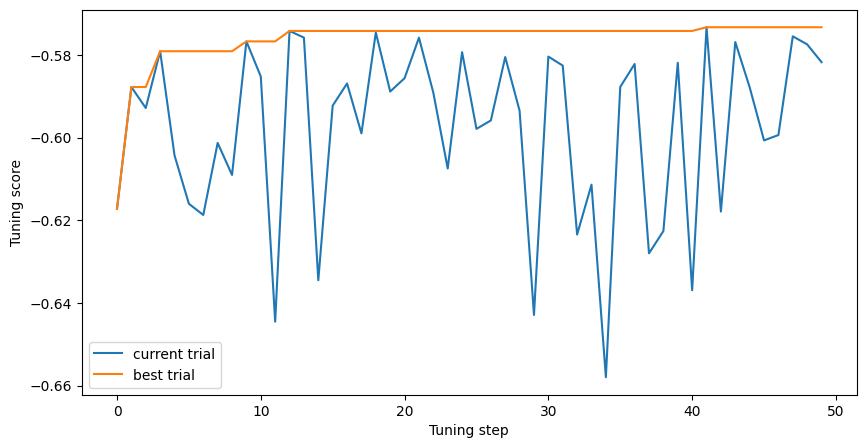

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(tuning_logs["score"], label="current trial")
plt.plot(tuning_logs["score"].cummax(), label="best trial")
plt.xlabel("Tuning step")
plt.ylabel("Tuning score")
plt.legend()
plt.show()

## Training a model with Keras Tuner *(Alternative approach)* 

TensorFlow Decision Forests is based on the Keras framework, and it is compatible with the [Keras tuner](https://keras.io/keras_tuner/#quick-introduction).

Currently, the **TF-DF Tuner** and the **Keras Tuner** are complementary.

*TF-DF Tuner*

- Automatic configuration of the objective.
- Automatic extraction of validation dataset (if needed).
- Support model self evaluation (e.g. out-of-bag evaluation).
- Distributed hyper-parameter tuning.
- Shared dataset access in between the trials: The tensorflow dataset is read only once, speeding-up tuning significantly on small datasets.

*Keras Tuner*

- Support tuning of the pre-processing parameters.
- Support hyper-band optimizer.
- Support custom objectives.

Let's tune a TF-DF model using the Keras tuner.

In [22]:
# Install the Keras tuner
!pip install keras-tuner -U -qq
import keras_tuner as kt

In [23]:
%%time

def build_model(hp):
  """Creates a model."""

  model = tfdf.keras.GradientBoostedTreesModel(
      min_examples=hp.Choice("min_examples", [2, 5, 7, 10]),
      categorical_algorithm=hp.Choice("categorical_algorithm", ["CART", "RANDOM"]),
      max_depth=hp.Choice("max_depth", [4, 5, 6, 7]),
      # The keras tuner convert automaticall boolean parameters to integers.
      use_hessian_gain=bool(hp.Choice("use_hessian_gain", [True, False])),
      shrinkage=hp.Choice("shrinkage", [0.02, 0.05, 0.10, 0.15]),
      num_candidate_attributes_ratio=hp.Choice("num_candidate_attributes_ratio", [0.2, 0.5, 0.9, 1.0]),
  )

  # Optimize the model accuracy as computed on the validation dataset.
  model.compile(metrics=["accuracy"])
  return model

keras_tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=50,
    overwrite=True,
    directory="/tmp/keras_tuning")

# Important: The tuning should not be done on the test dataset.

# Extract a validation dataset from the training dataset. The new training
# dataset is called the "sub-training-dataset".

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

sub_train_df, sub_valid_df = split_dataset(train_df)
sub_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(sub_train_df, label="income")
sub_valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(sub_valid_df, label="income")

# Tune the model
keras_tuner.search(sub_train_ds, validation_data=sub_valid_ds)

Trial 50 Complete [00h 00m 05s]
val_accuracy: 0.8727272748947144

Best val_accuracy So Far: 0.8779433965682983
Total elapsed time: 00h 04m 28s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


CPU times: user 7min 52s, sys: 1min 22s, total: 9min 14s
Wall time: 4min 28s


The best hyper-parameter are available with `get_best_hyperparameters`:


In [24]:
# Tune the model
best_hyper_parameters = keras_tuner.get_best_hyperparameters()[0].values
print("Best hyper-parameters:", keras_tuner.get_best_hyperparameters()[0].values)

Best hyper-parameters: {'min_examples': 7, 'categorical_algorithm': 'CART', 'max_depth': 7, 'use_hessian_gain': 0, 'shrinkage': 0.15, 'num_candidate_attributes_ratio': 0.9}


The model should be re-trained with the best hyper-parameters:

In [25]:
%set_cell_height 300
# Train the model
# The keras tuner convert automaticall boolean parameters to integers.
best_hyper_parameters["use_hessian_gain"] = bool(best_hyper_parameters["use_hessian_gain"])
best_model = tfdf.keras.GradientBoostedTreesModel(**best_hyper_parameters)
best_model.fit(train_ds, verbose=2)

<IPython.core.display.Javascript object>

Use /tmpfs/tmp/tmpau6vzbt0 as temporary training directory


Reading training dataset...


Training tensor examples:
Features: {'age': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'workclass': <tf.Tensor 'data_13:0' shape=(None,) dtype=string>, 'fnlwgt': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'education': <tf.Tensor 'data_3:0' shape=(None,) dtype=string>, 'education_num': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'marital_status': <tf.Tensor 'data_7:0' shape=(None,) dtype=string>, 'occupation': <tf.Tensor 'data_9:0' shape=(None,) dtype=string>, 'relationship': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'race': <tf.Tensor 'data_10:0' shape=(None,) dtype=string>, 'sex': <tf.Tensor 'data_12:0' shape=(None,) dtype=string>, 'capital_gain': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'capital_loss': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hours_per_week': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'native_country': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>}
Label: Tensor("data_14:0", shape=(None,), dtype=int64)
Weights

Normalized tensor features:
 {'age': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'workclass': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_13:0' shape=(None,) dtype=string>), 'fnlwgt': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'education': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_3:0' shape=(None,) dtype=string>), 'education_num': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'marital_status': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_7:0' shape=(None,) dtype=string>), 'occupation': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_9:0' shape=(None,) dtype=string>), 'relationship': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_11:0' shape=(None,) d

Training dataset read in 0:00:00.372057. Found 22792 examples.


Training model...


[INFO 2023-02-01T12:16:10.151802063+00:00 kernel.cc:756] Start Yggdrasil model training
[INFO 2023-02-01T12:16:10.15183364+00:00 kernel.cc:757] Collect training examples
[INFO 2023-02-01T12:16:10.151922389+00:00 kernel.cc:388] Number of batches: 23
[INFO 2023-02-01T12:16:10.151938239+00:00 kernel.cc:389] Number of examples: 22792


[INFO 2023-02-01T12:16:10.159359793+00:00 data_spec_inference.cc:303] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column native_country (40 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 2023-02-01T12:16:10.15940551+00:00 data_spec_inference.cc:303] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column occupation (13 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 2023-02-01T12:16:10.159448183+00:00 data_spec_inference.cc:303] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column workclass (7 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000


[INFO 2023-02-01T12:16:10.16406424+00:00 kernel.cc:774] Training dataset:
Number of records: 22792
Number of columns: 15

Number of columns by type:
	CATEGORICAL: 9 (60%)
	NUMERICAL: 6 (40%)

Columns:

CATEGORICAL: 9 (60%)
	0: "__LABEL" CATEGORICAL integerized vocab-size:3 no-ood-item
	4: "education" CATEGORICAL has-dict vocab-size:17 zero-ood-items most-frequent:"HS-grad" 7340 (32.2043%)
	8: "marital_status" CATEGORICAL has-dict vocab-size:8 zero-ood-items most-frequent:"Married-civ-spouse" 10431 (45.7661%)
	9: "native_country" CATEGORICAL num-nas:407 (1.78571%) has-dict vocab-size:41 num-oods:1 (0.00446728%) most-frequent:"United-States" 20436 (91.2933%)
	10: "occupation" CATEGORICAL num-nas:1260 (5.52826%) has-dict vocab-size:14 num-oods:1 (0.00464425%) most-frequent:"Prof-specialty" 2870 (13.329%)
	11: "race" CATEGORICAL has-dict vocab-size:6 zero-ood-items most-frequent:"White" 19467 (85.4115%)
	12: "relationship" CATEGORICAL has-dict vocab-size:7 zero-ood-items most-frequent:"Hus

[INFO 2023-02-01T12:16:12.125174473+00:00 early_stopping.cc:53] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.580282


[INFO 2023-02-01T12:16:12.132791707+00:00 kernel.cc:905] Export model in log directory: /tmpfs/tmp/tmpau6vzbt0 with prefix d9f51fa1e24f4e5a


[INFO 2023-02-01T12:16:12.136270135+00:00 kernel.cc:923] Save model in resources


[INFO 2023-02-01T12:16:12.138808984+00:00 abstract_model.cc:849] Model self evaluation:
Task: CLASSIFICATION
Label: __LABEL
Loss (BINOMIAL_LOG_LIKELIHOOD): 0.580282

Accuracy: 0.872067  CI95[W][0 1]
ErrorRate: : 0.127933


Confusion Table:
truth\prediction
   0     1    2
0  0     0    0
1  0  1572   92
2  0   197  398
Total: 2259

One vs other classes:



[INFO 2023-02-01T12:16:12.156739509+00:00 kernel.cc:1214] Loading model from path /tmpfs/tmp/tmpau6vzbt0/model/ with prefix d9f51fa1e24f4e5a


[INFO 2023-02-01T12:16:12.172480351+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2023-02-01T12:16:12.172513629+00:00 kernel.cc:1046] Use fast generic engine


Model trained in 0:00:02.027041


Compiling model...


Model compiled.


We can then evaluate the tuned model:

In [26]:
# Evaluate the model
best_model.compile(["accuracy"])
tuned_test_accuracy = best_model.evaluate(test_ds, return_dict=True, verbose=0)["accuracy"]
print(f"Test accuracy with the Keras Tuner: {tuned_test_accuracy:.4f}")

Test accuracy with the Keras Tuner: 0.8747
